### Experiments with training spectral bias

Imports

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [2]:
save = False

Only for python script: uncomment if running on cluster

In [3]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [4]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [7]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        num_freqs = torch.randint(min_freq, max_freq * 2, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [8]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 15)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 10, 15)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [9]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

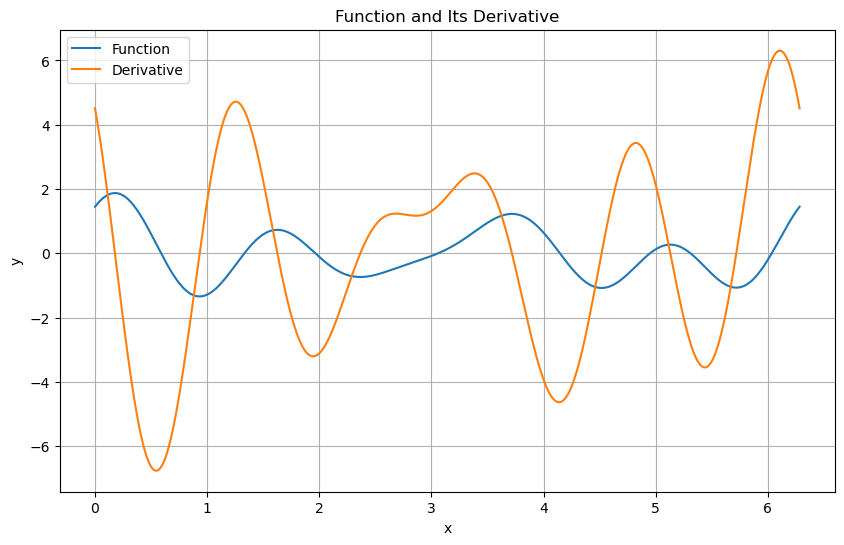

In [142]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [12]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [13]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [14]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [15]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [16]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Function to train model

In [17]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [18]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

criterion = torch.nn.MSELoss()

In [19]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

In [20]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Create models

In [21]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

In [22]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)

In [23]:
# train_losses, test_losses = model_training(L3ModelK3, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Plot results

In [39]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

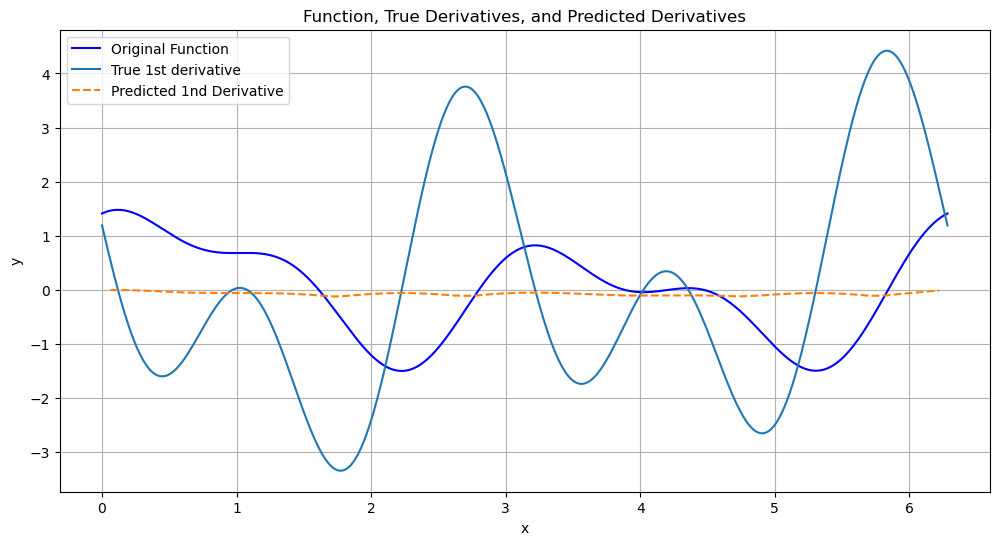

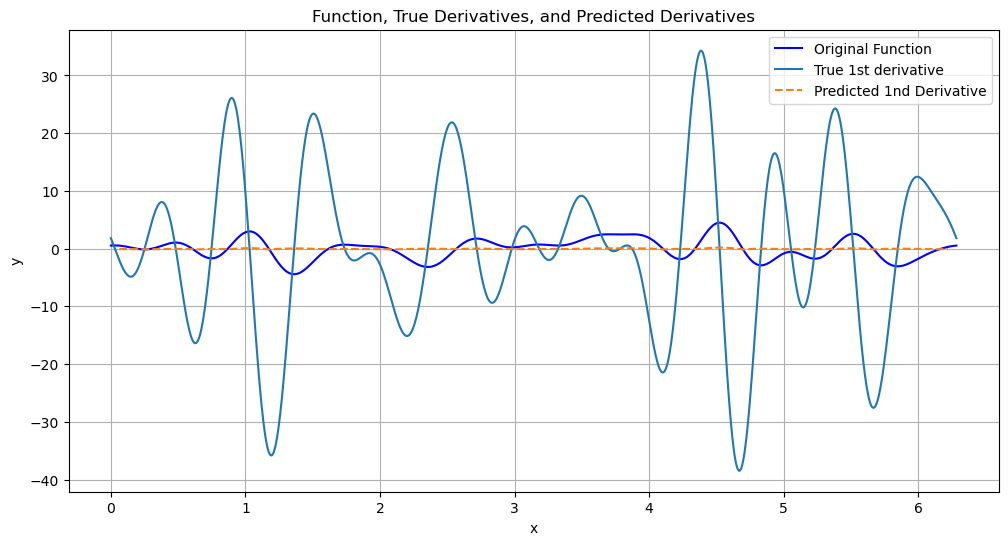

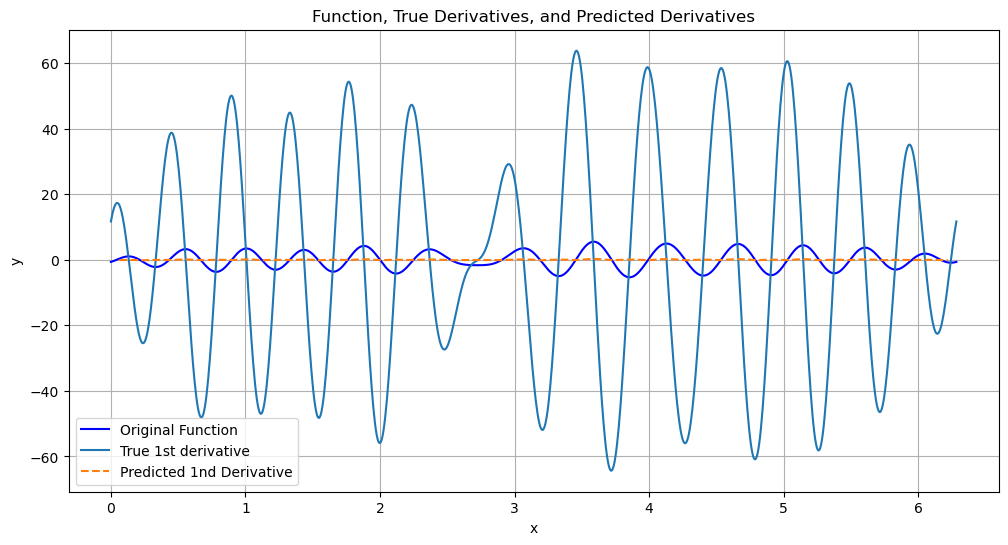

In [144]:
plot_all_outputs(L3ModelK3, model_name = 'L3ModelK3')

In [27]:
print_metrics(L3ModelK3)

NMSE over low freq test functions: 0.9994839429855347
NMSE over general freq test functions: 0.9994645118713379
NMSE over high freq test functions: 0.9995222091674805


In [42]:
print(L3ModelK3)

SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)


**3 layer model with kernel size 9**

In [43]:
set_seed(seed)
L3ModelK9 = SimpleCNN(n_layers=3, kernel_size=9)

In [44]:
# train_losses, test_losses = model_training(L3ModelK9, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

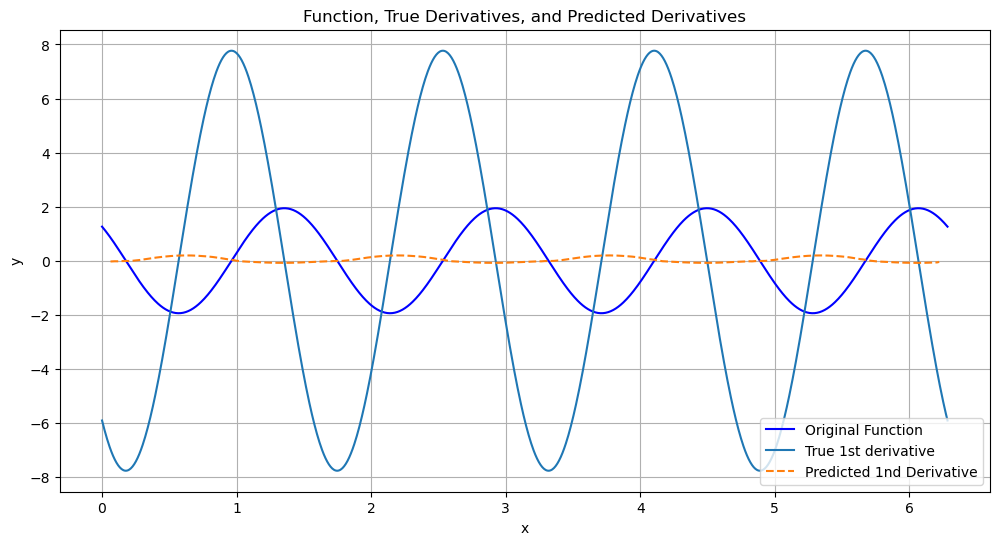

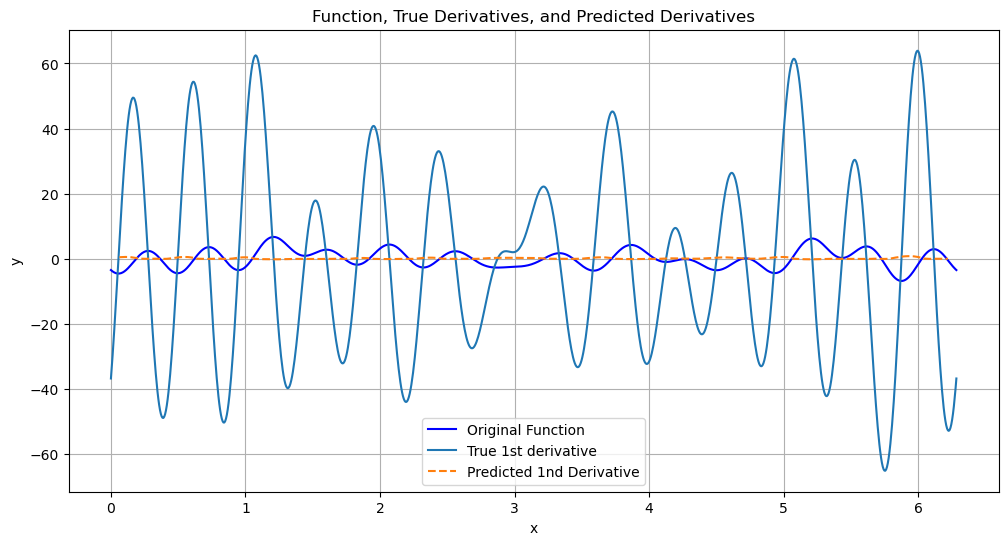

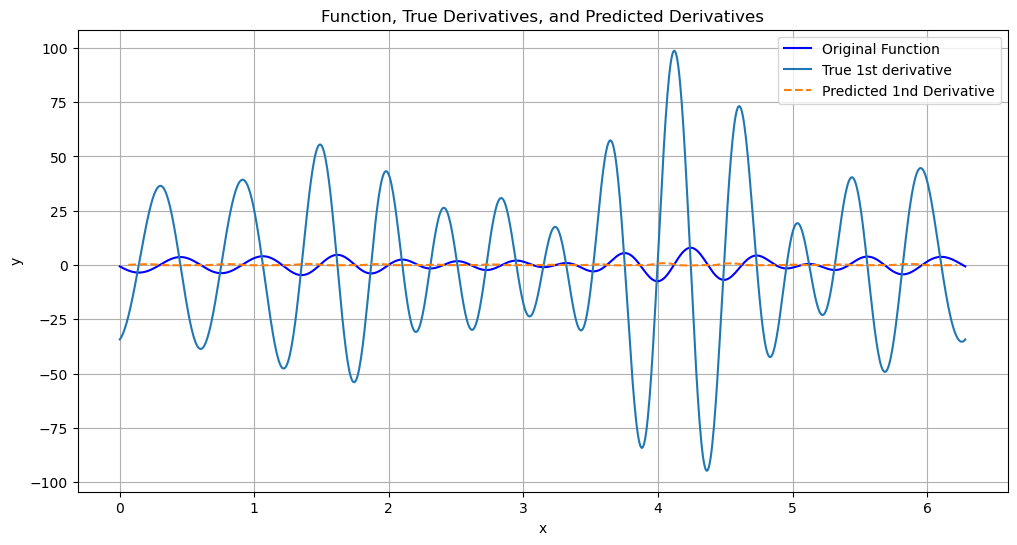

In [46]:
plot_all_outputs(L3ModelK9, model_name='L3ModelK9')

In [47]:
print_metrics(L3ModelK9)
print(L3ModelK9)

NMSE over low freq test functions: 0.9949268102645874
NMSE over general freq test functions: 0.9951961636543274
NMSE over high freq test functions: 0.9954105019569397
SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(64, 1, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)


**3 layer model with kernel size 12**

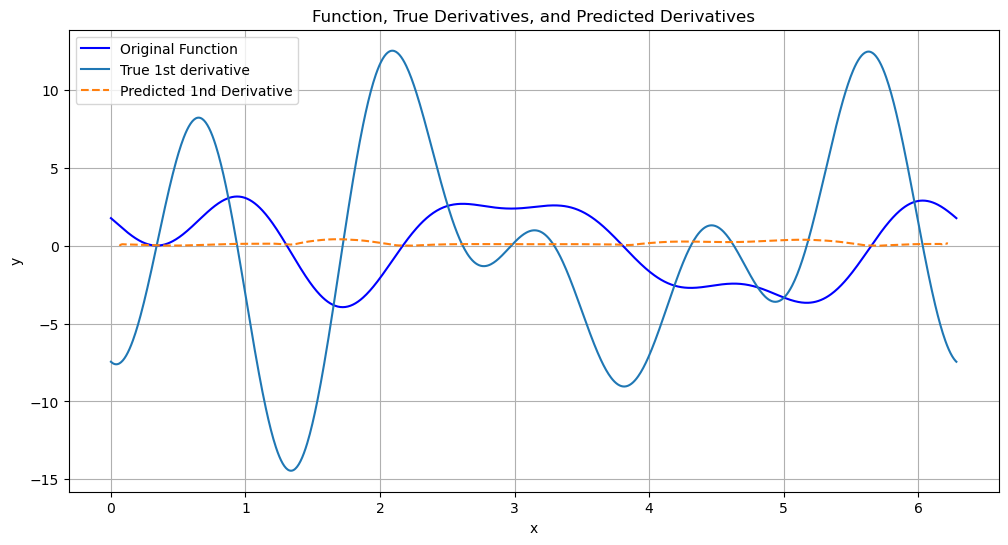

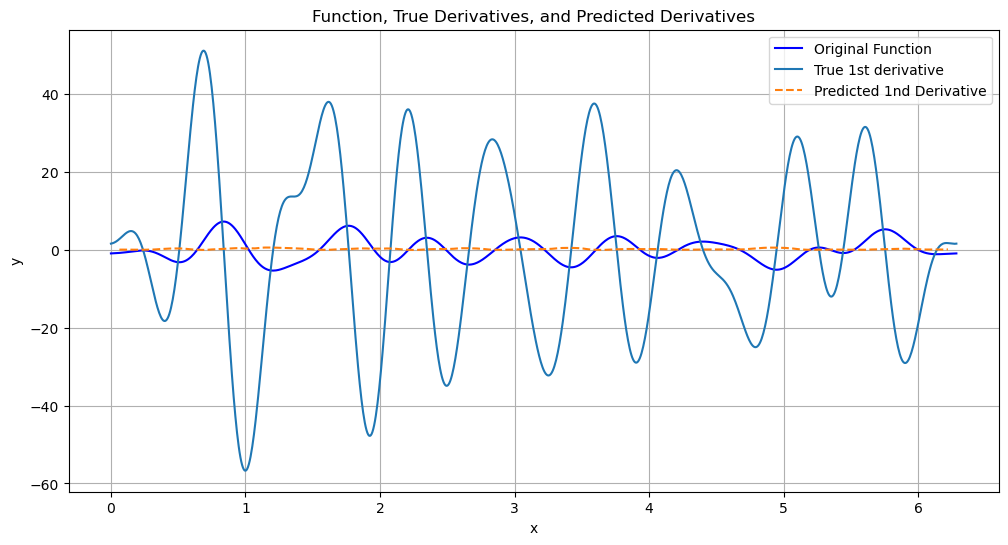

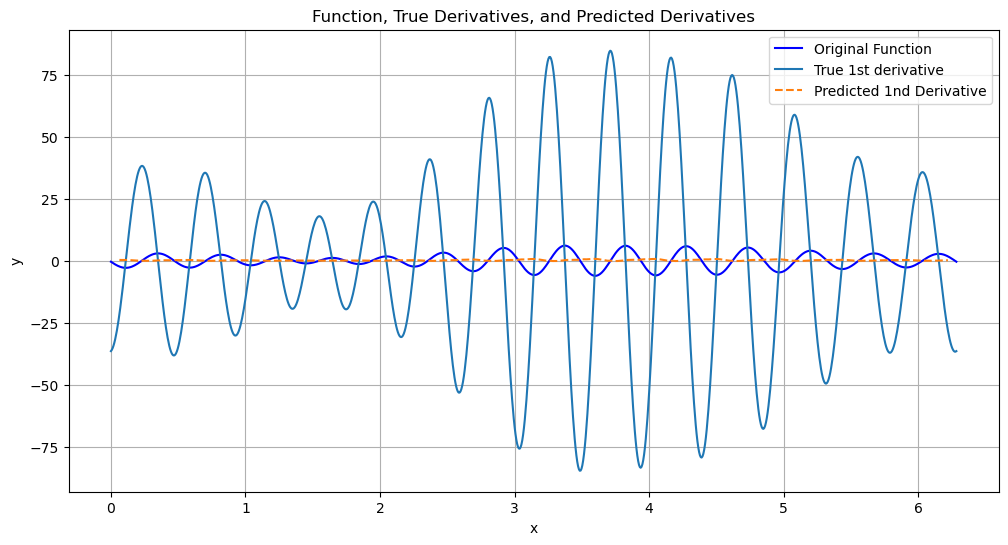

In [58]:
set_seed(seed)
L3ModelK15 = SimpleCNN(n_layers=3, kernel_size=15)
plot_all_outputs(L3ModelK15, model_name='L3ModelK15')

## Trying to create the colormap

Deprecated version

In [69]:
# def compute_fft_and_max_freq(functions):
#     fft_amplitudes = []
#     max_frequencies = []
#     T = 2*np.pi
#     N = 1000

#     frequencies = np.fft.fftfreq(N, T/(2*np.pi*N))
#     positive_freq_indices = frequencies >= 0

#     # freqs = freqs * (num_points / (2*np.pi))

#     for function in functions:
#         F = np.fft.fft(function)
#         magnitudes = np.abs(F) / N
        
#         # Consider only positive frequencies
#         positive_magnitudes = magnitudes[positive_freq_indices]
#         positive_freqs = frequencies[positive_freq_indices]
        
#         fft_amplitudes.append(positive_magnitudes)
        
#         # Maximum frequency based on the highest amplitude
#         max_freq = positive_freqs[np.argmax(positive_magnitudes)]
#         max_frequencies.append(max_freq)
    
#     return np.array(fft_amplitudes), np.array(max_frequencies), positive_freqs

# def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0):
#     # Sort functions by the maximum frequency
#     sorted_indices = np.argsort(-max_frequencies)  # Sort in descending order
#     sorted_fft = fft_amplitudes[sorted_indices]

#     plt.figure(figsize=(10, 6))
#     im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)])
#     plt.colorbar(im, label='Amplitude')
#     plt.xlabel('Frequency (rad/s)')
#     plt.ylabel('Function Index (sorted by max frequency)')
#     plt.title(f'FFT Amplitude Heatmap for {fun_type}')
#     plt.xlim([xmin, xmax])
#     plt.show()


**Correct version with dataloader as input**

In [126]:
def compute_fft_and_max_freq(dataloader, compute_output=False, model=None):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # Calculate frequencies for the FFT
    frequencies = torch.fft.fftfreq(N, T / (2 * torch.pi * N))
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    # Iterate over each batch
    for functions, _ in dataloader:  # Note that derivatives are ignored in this loop
        
        if compute_output:
            functions = model(functions.unsqueeze(1)).squeeze()
            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        # Compute FFT using PyTorch
        F = torch.fft.fft(functions)
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0):
    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()
    
    # Sort functions by the maximum frequency
    sorted_indices = np.argsort(-max_frequencies)  # Sort in descending order
    sorted_fft = fft_amplitudes[sorted_indices]

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)])
    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim([xmin, xmax])
    plt.show()


In [147]:
def plot_heatmaps(model):
    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(low_freq_dataloader,\
        compute_output=True, model=model)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Low freq model outputs', xmin=0, xmax=6)

    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(general_freq_dataloader,\
        compute_output=True, model=model)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='General freq model outputs', xmin=0, xmax=16)

    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(high_freq_dataloader,\
        compute_output=True, model=model)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='High freq model outputs', xmin=10, xmax=16)


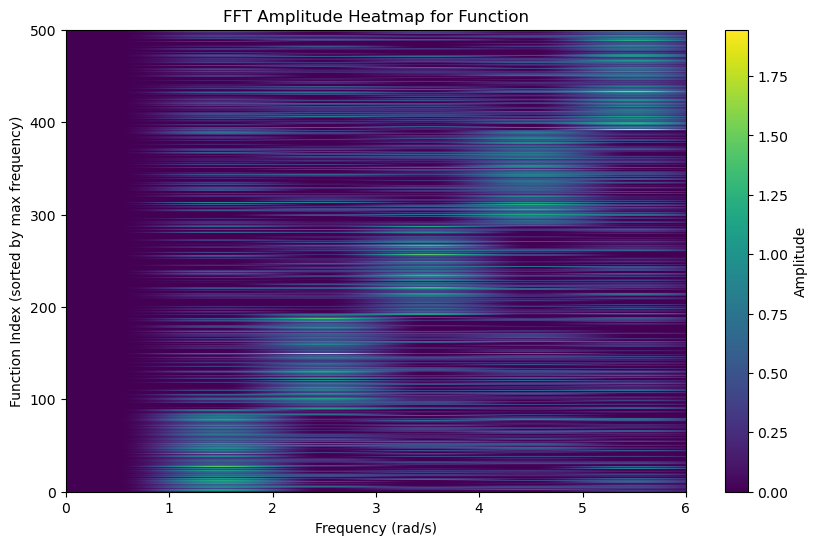

In [127]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(low_freq_dataloader)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Function', xmin=0, xmax=6)

### Heatmap for low frequency dataset

In [121]:
# fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(low_freq_functions)
# plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Function', xmin=0, xmax=6)
# # Note: we should let xlim = max_freq + 1 since the FFT calculates positive frequency past the peak
# # i.e., the frequency will only go to 0 at x=6 for sin(5x)

### Heatmap for general frequencies

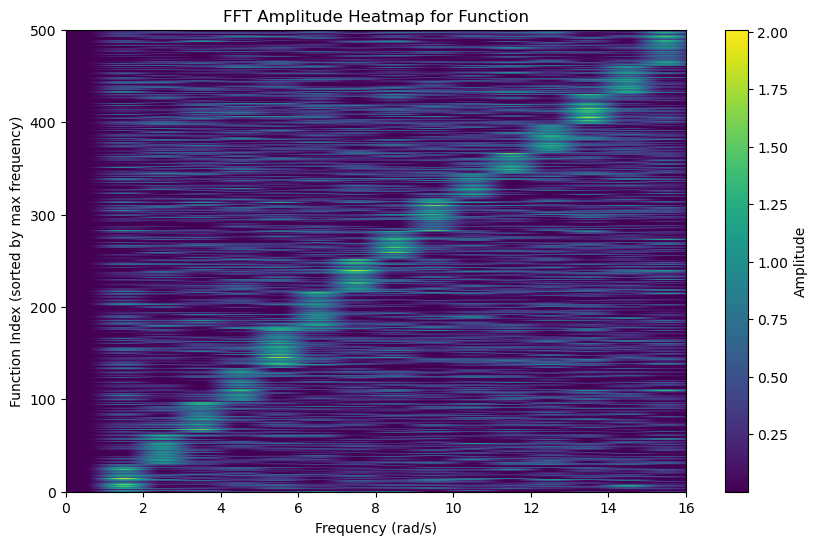

In [123]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(general_freq_dataloader)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Function', xmin=0, xmax=16)

### Heatmap for high frequencies

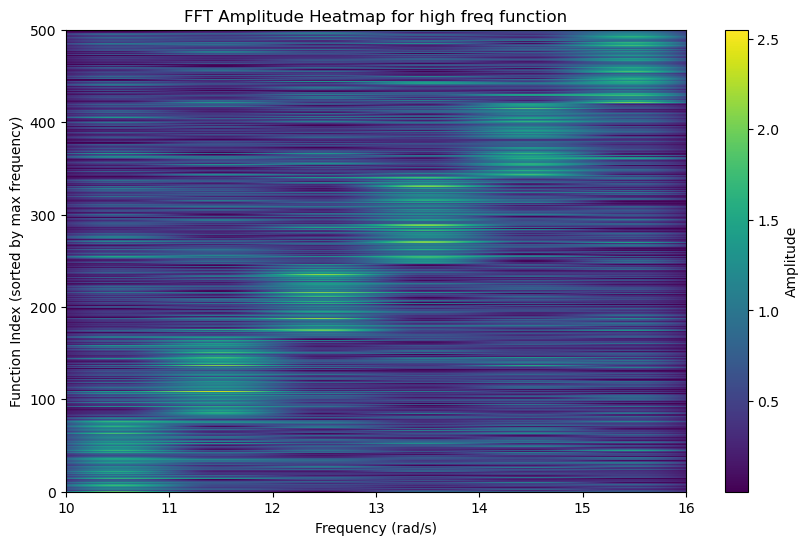

In [124]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(high_freq_dataloader)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='high freq function', xmin=10, xmax=16)

## Frequencies of model outputs

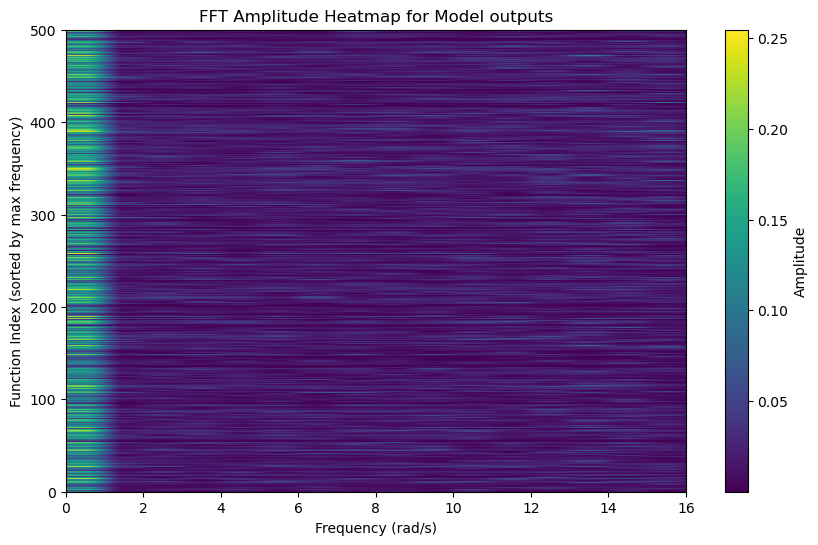

In [132]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(general_freq_dataloader,\
    compute_output=True, model=L3ModelK15)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Model outputs', xmin=0, xmax=16)

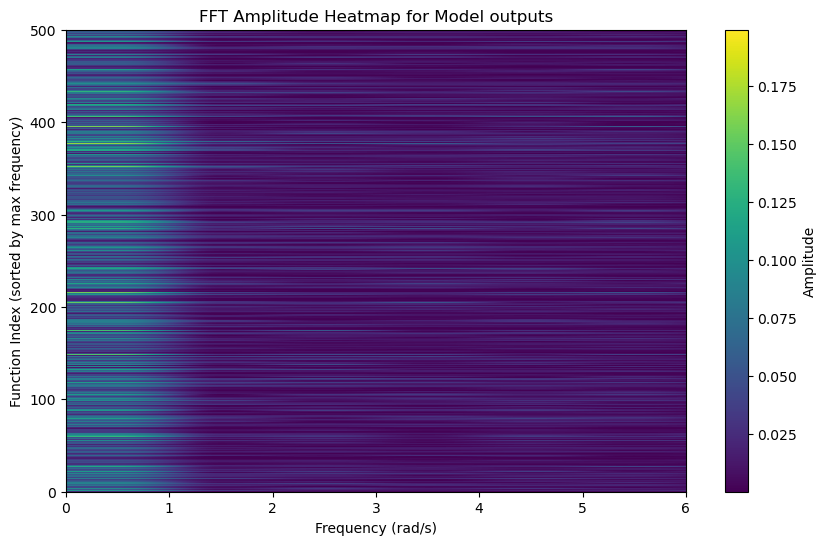

In [134]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(low_freq_dataloader,\
    compute_output=True, model=L3ModelK15)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Model outputs', xmin=0, xmax=6)

In [135]:
print(compute_mse(train_dataloader_l, L3ModelK15)[1])

1.0060895681381226


## Trained model

Epoch [1/1000], Train Loss: 380.9321, Test Loss: 230.4279
Epoch [2/1000], Train Loss: 149.4013, Test Loss: 29.3239
Epoch [3/1000], Train Loss: 33.1259, Test Loss: 15.0070
Epoch [4/1000], Train Loss: 15.3406, Test Loss: 11.0443
Epoch [5/1000], Train Loss: 10.8422, Test Loss: 8.3859
Epoch [6/1000], Train Loss: 9.4499, Test Loss: 6.8368
Epoch [7/1000], Train Loss: 8.4654, Test Loss: 6.2899
Epoch [8/1000], Train Loss: 7.8649, Test Loss: 5.9778
Epoch [9/1000], Train Loss: 7.5430, Test Loss: 5.7098
Epoch [10/1000], Train Loss: 7.1118, Test Loss: 5.4552
Epoch [11/1000], Train Loss: 6.5264, Test Loss: 5.2224
Epoch [12/1000], Train Loss: 6.4542, Test Loss: 5.0063
Epoch [13/1000], Train Loss: 6.2428, Test Loss: 4.7966
Epoch [14/1000], Train Loss: 5.9315, Test Loss: 4.5820
Epoch [15/1000], Train Loss: 5.6140, Test Loss: 4.3734
Epoch [16/1000], Train Loss: 5.5439, Test Loss: 4.6817
Epoch [17/1000], Train Loss: 5.5691, Test Loss: 4.3875
Epoch [18/1000], Train Loss: 5.0490, Test Loss: 3.8749
Epoch [

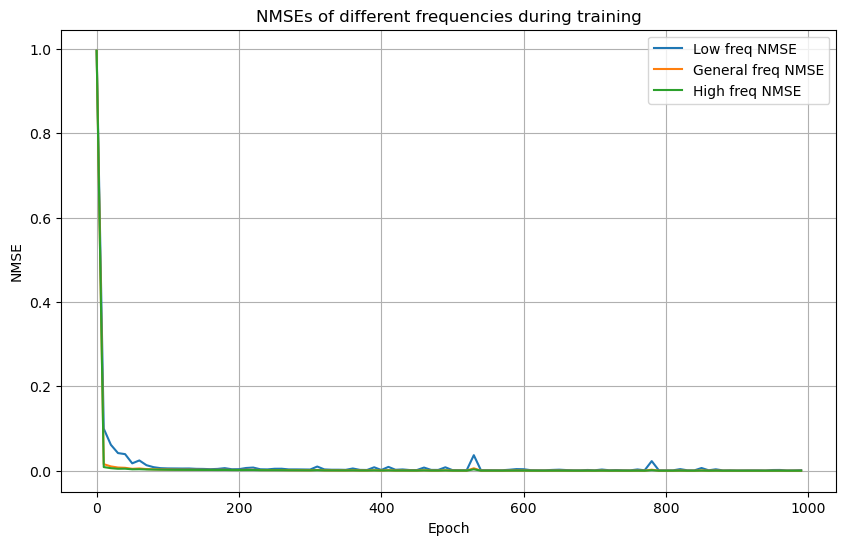

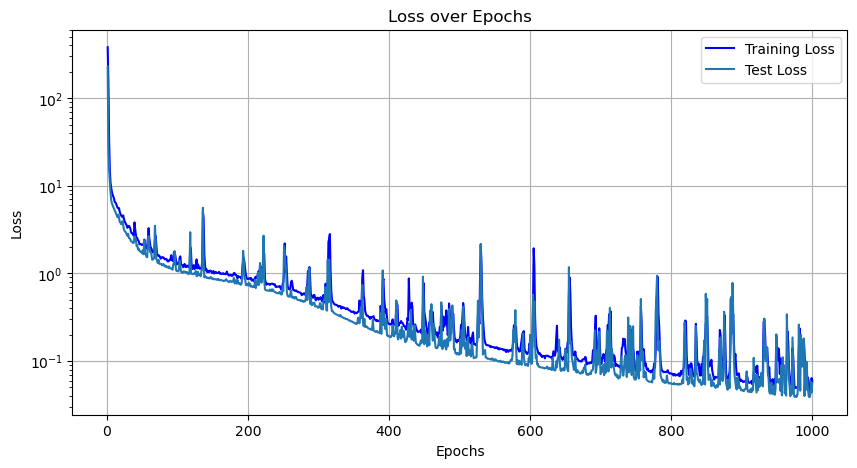

In [136]:
set_seed(seed)
L3ModelK9_trained = SimpleCNN(n_layers=3, kernel_size=9)

train_losses, test_losses = model_training(L3ModelK9_trained, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

### Frequency heatmap of general frequency data on model output

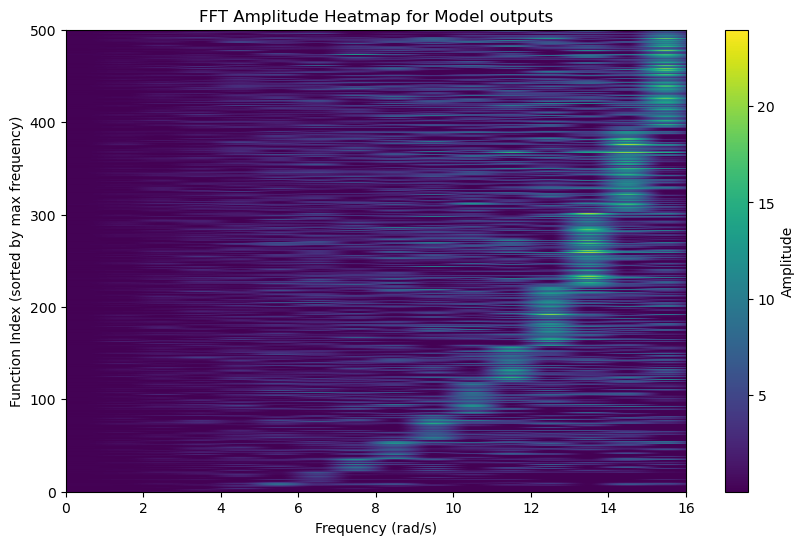

In [137]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(general_freq_dataloader,\
    compute_output=True, model=L3ModelK9_trained)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Model outputs', xmin=0, xmax=16)

### Low frequency heatmap of model output

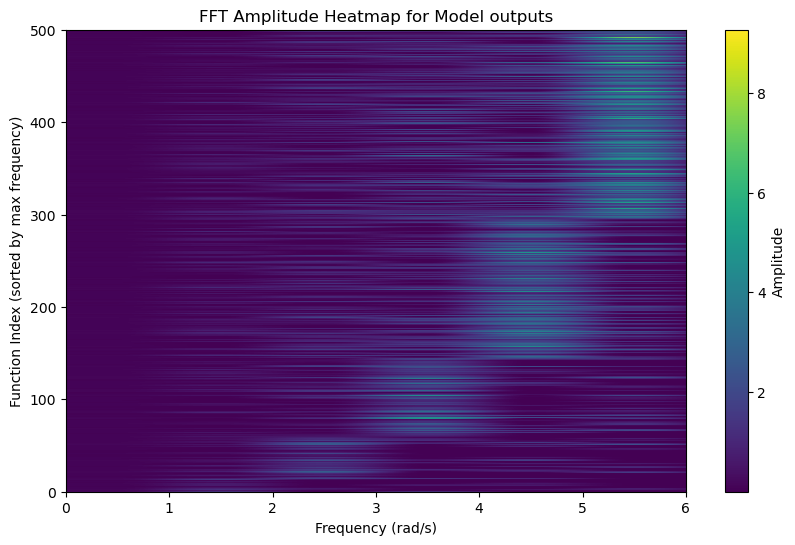

In [138]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(low_freq_dataloader,\
    compute_output=True, model=L3ModelK9_trained)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Model outputs', xmin=0, xmax=6)

### High frequency heatmap of model output

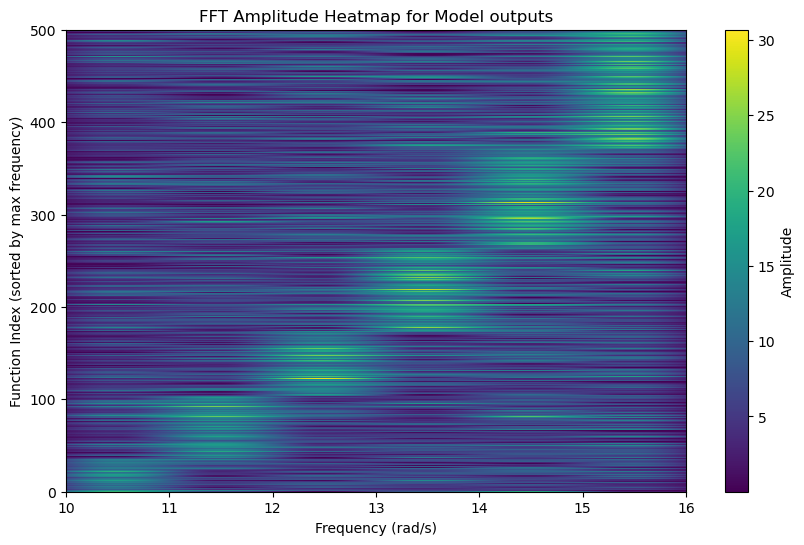

In [140]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(high_freq_dataloader,\
    compute_output=True, model=L3ModelK9_trained)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Model outputs', xmin=10, xmax=16)

## Experiments with deeper models

### Training on low frequency dataset only

Epoch [1/1000], Train Loss: 15.7158, Test Loss: 12.5928
Epoch [2/1000], Train Loss: 6.6628, Test Loss: 2.7900
Epoch [3/1000], Train Loss: 2.3719, Test Loss: 2.2377
Epoch [4/1000], Train Loss: 1.7189, Test Loss: 1.7387
Epoch [5/1000], Train Loss: 1.5165, Test Loss: 1.5565
Epoch [6/1000], Train Loss: 1.3531, Test Loss: 1.3527
Epoch [7/1000], Train Loss: 1.2288, Test Loss: 1.2953
Epoch [8/1000], Train Loss: 1.1365, Test Loss: 1.0964
Epoch [9/1000], Train Loss: 0.9853, Test Loss: 1.0103
Epoch [10/1000], Train Loss: 0.9024, Test Loss: 0.9725
Epoch [11/1000], Train Loss: 0.8453, Test Loss: 0.8165
Epoch [12/1000], Train Loss: 0.7333, Test Loss: 0.7431
Epoch [13/1000], Train Loss: 0.6687, Test Loss: 0.6867
Epoch [14/1000], Train Loss: 0.6259, Test Loss: 0.6349
Epoch [15/1000], Train Loss: 0.6098, Test Loss: 0.5773
Epoch [16/1000], Train Loss: 0.5689, Test Loss: 0.5931
Epoch [17/1000], Train Loss: 0.5236, Test Loss: 0.5230
Epoch [18/1000], Train Loss: 0.4769, Test Loss: 0.4662
Epoch [19/1000], 

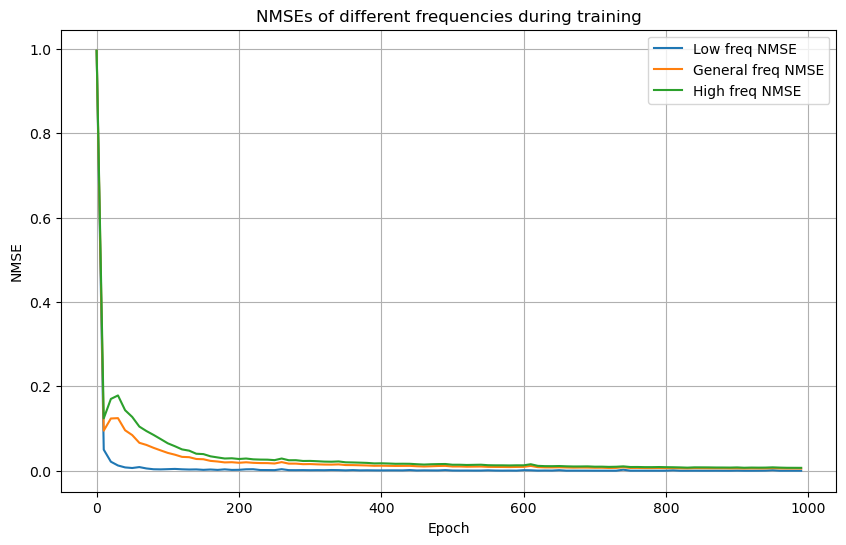

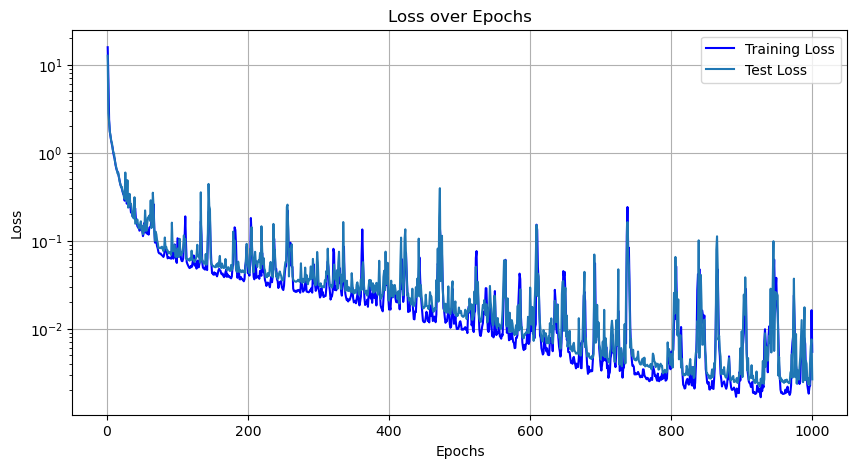

In [145]:
set_seed(seed)
L3ModelK9_low = SimpleCNN(n_layers=3, kernel_size=9)

train_losses, test_losses = model_training(L3ModelK9_low, train_dataloader_l, test_dataloader_l,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [146]:
print_metrics(L3ModelK9_low)

NMSE over low freq test functions: 0.00013144544209353626
NMSE over general freq test functions: 0.006148839835077524
NMSE over high freq test functions: 0.008195887319743633


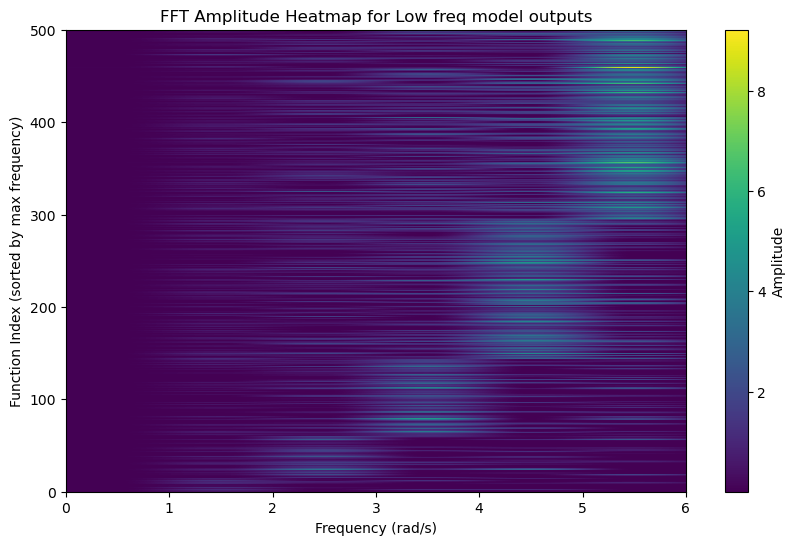

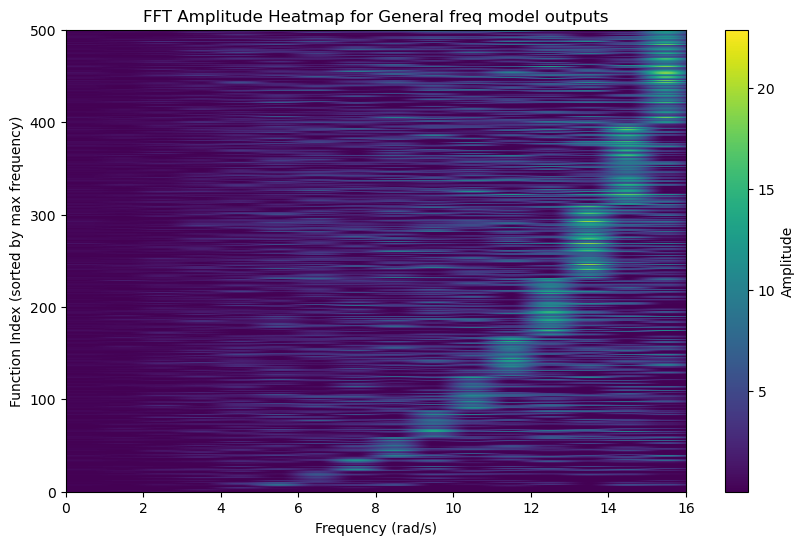

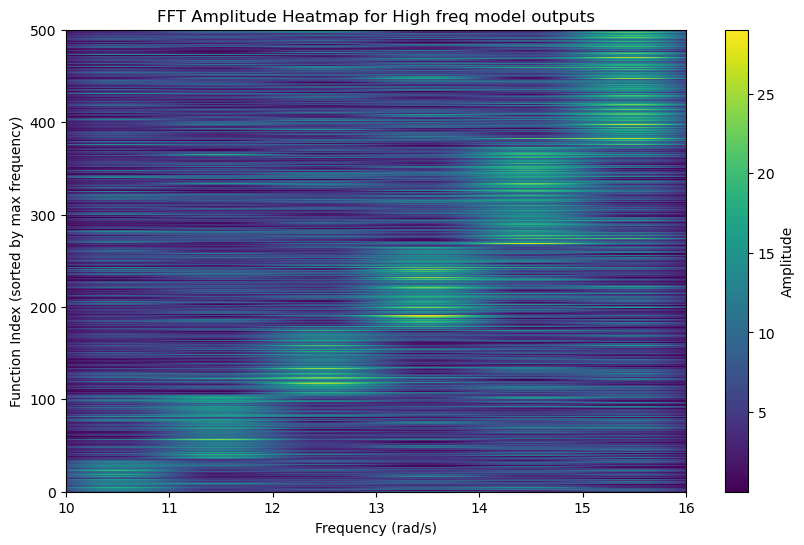

In [148]:
plot_heatmaps(L3ModelK9_low)